In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline # This import should now work correctly
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# XGBoost Library
import xgboost as xgb

# Import Necessary Libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasClassifier, KerasRegressor
import keras_tuner as kt



# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
!pip install scikeras


In [ ]:
# -------------- Step 1: Load and Explore the Data --------------
# Load the dataset (Adjust the path as necessary)
data = pd.read_csv("/content/drive/MyDrive/diabetes.csv")

In [ ]:
pip install tensorflow keras

Preprocessing Your Data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Your data loading and preprocessing here
X = data.drop(columns='Diabetes')  # Features
y = data['Diabetes']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Create positive and negative pairs
def make_pairs(X, y):
    pairs = []
    labels = []
    num_classes = len(np.unique(y))
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    for idx1 in range(len(X)):
        # Create a positive pair
        current_image = X[idx1]
        label = y[idx1]
        idx2 = np.random.choice(digit_indices[label])
        positive_image = X[idx2]

        pairs += [[current_image, positive_image]]
        labels += [1]

        # Create a negative pair
        label2 = (label + 1) % 2  # Pick a different class
        idx2 = np.random.choice(digit_indices[label2])
        negative_image = X[idx2]

        pairs += [[current_image, negative_image]]
        labels += [0]

    return np.array(pairs), np.array(labels)

pairs_train, labels_train = make_pairs(X_train.values, y_train.values)
pairs_test, labels_test = make_pairs(X_test.values, y_test.values)


Define the Siamese Network

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential

# Define the base network (feature extraction network)
def create_base_network(input_shape):
    model = Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    return model

# Define the input shape
input_shape = X_train.shape[1:]

# Create the base network
base_network = create_base_network(input_shape)

# Define the inputs
input_a = tf.keras.Input(shape=input_shape)
input_b = tf.keras.Input(shape=input_shape)

# The two networks share weights
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the L1 distance between the two outputs
distance = layers.Lambda(lambda tensors: tf.math.abs(tensors[0] - tensors[1]))([processed_a, processed_b])

# Add a fully connected layer for the binary output (0 or 1)
output = layers.Dense(1, activation='sigmoid')(distance)

# Define the full Siamese model
siamese_model = Model(inputs=[input_a, input_b], outputs=output)

# Compile the model
siamese_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
siamese_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 17)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 17)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 128)            │         35,328 │ input_layer_1[0][0],   │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128)            │              0 │ sequential[0][0],      │
│                           │                        │                │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │            129 │ lambda[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 35,457 (138.50 KB)

 Trainable params: 35,457 (138.50 KB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [ ]:
# Train the Siamese Neural Network
history = siamese_model.fit(
    [pairs_train[:, 0], pairs_train[:, 1]], labels_train,
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
    epochs=20,
    batch_size=32
)


Epoch 1/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5779 - loss: 0.7904 - val_accuracy: 0.7165 - val_loss: 0.6411
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7616 - loss: 0.5281 - val_accuracy: 0.7676 - val_loss: 0.5071
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7961 - loss: 0.4822 - val_accuracy: 0.8075 - val_loss: 0.4616
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8031 - loss: 0.4597 - val_accuracy: 0.8133 - val_loss: 0.4501
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8120 - loss: 0.4393 - val_accuracy: 0.8261 - val_loss: 0.4273
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8281 - loss: 0.4134 - val_accuracy: 0.8242 - val_loss: 0.4311
Epoch 7/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8277 - loss: 0.4275 - val_accuracy: 0.8346 - val_loss: 0.4064
Epoch 8/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8349 - loss: 0.4053 - val_accuracy: 0.

Evaluate the Model

In [ ]:
# Evaluate the model on the test data
loss, accuracy = siamese_model.evaluate([pairs_test[:, 0], pairs_test[:, 1]], labels_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8739 - loss: 0.3424
Test Accuracy: 86.56%


Evaluation Metrics

In [ ]:
from sklearn.metrics import classification_report

y_pred = siamese_model.predict([pairs_test[:, 0], pairs_test[:, 1]])
y_pred = (y_pred > 0.5).astype("int32")
print(classification_report(labels_test, y_pred))


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      1291
           1       0.83      0.91      0.87      1291

    accuracy                           0.87      2582
   macro avg       0.87      0.87      0.87      2582
weighted avg       0.87      0.87      0.87      2582



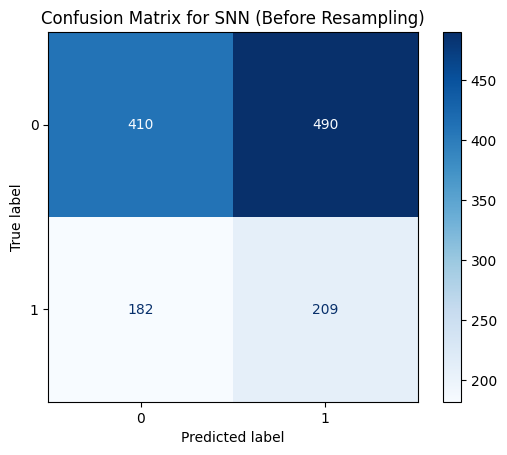

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


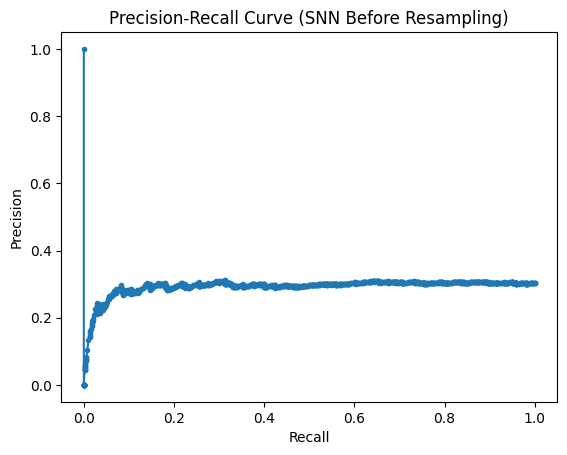

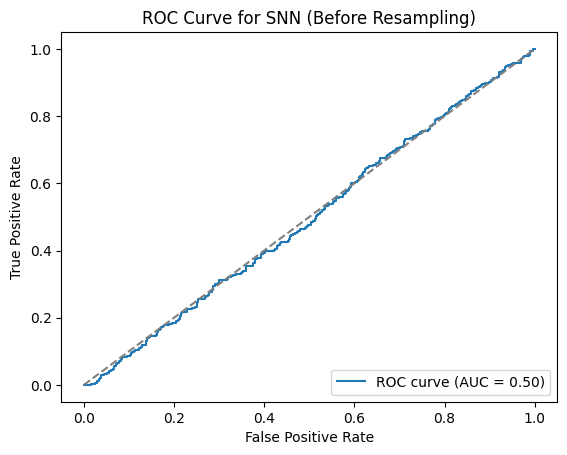

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, auc

# Assuming y_test contains the true labels and y_pred contains the predicted labels (0 or 1)
# Assuming y_score contains the predicted probabilities from the SNN model (probabilities for class 1)

# 1. Confusion Matrix
# y_pred was likely created using a Siamese network, which receives pairs of samples as inputs
# Use only the first half of the predictions to match the number of samples in y_test
cm = confusion_matrix(y_test, y_pred[:len(y_test)])

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for SNN (Before Resampling)')
plt.show()

# 2. Precision-Recall Curve
# Calculate y_score
y_score = siamese_model.predict([pairs_test[:, 0], pairs_test[:, 1]]) # Assuming pairs_test is defined and contains your test data

precision, recall, thresholds = precision_recall_curve(y_test, y_score[:len(y_test)])

# Plot Precision-Recall Curve
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve (SNN Before Resampling)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# 3. ROC Curve and AUC
fpr, tpr, thresholds_roc = roc_curve(y_test, y_score[:len(y_test)])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Reference line for a random classifier
plt.title('ROC Curve for SNN (Before Resampling)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')